In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

import torch.optim as optim


# Data preprocessing utils : 
from torchvision.transforms import Compose
from torchvision import transforms
from torch.utils.data import DataLoader

# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

# my defined model
from utils.acdc_dataset import *
from utils.funcs import *
from utils.vqvae import *

In [2]:
######################## Parameters ######################

# dataset params :
L = 128  # length of input images
data_modality = 'SEG'  # either 'SEG' to use segmentation dataset or 'MRI' for gray-scale MRIs


# training params
BATCH_SIZE = 32
lr = 5e-4
epochs = 100
model_name = 'saved_models/seg_rq_model_401.pth'


# model hyper-params :
K =  128 # num_embeddings
D =  64  # embedding_dim 
downsampling_factor = 8

use_residual = True # swicth to True if wants to use RQ-VAE
num_quantizers = 2
shared_codebook = False

beta = .25
decay = .8

kmeans_init = True
kmeans_iters = 10

In [3]:
#################### dataset init ######################
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


train_dataset = load_dataset(train_set_path, modality= data_modality)
test_dataset  = load_dataset(test_set_path, modality= data_modality)


if data_modality == 'SEG':
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        One_hot_Transform(num_classes=4)
        ])
else : 
    input_transforms = Compose([
        transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
        PercentileClip(lower_percentile=1, upper_percentile=99),
        MinMaxNormalize(min_value=0.0, max_value=1.0),
        ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = False)



In [4]:

# instanciate model :

VQ_VAE =  VQVAE(embedding_dim= D,
                num_embeddings= K,
                downsampling_factor= downsampling_factor,
                residual = use_residual,
                num_quantizers = num_quantizers,
                shared_codebook = shared_codebook,
                beta = beta,
                decay = decay,
                data_mod = data_modality,
                kmeans_init = kmeans_init,
                kmeans_iters = kmeans_iters
                    )

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = VQ_VAE.to(device)

optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)


In [5]:

model.train()

train_loss_values    = []
commit_loss_values   = []
val_loss_values      = []


best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss  = []
    commit_loss = []

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, indices, commitement_Loss = model(inputs)
            
            # Loss and backward
            all_loss = model.loss_function(output, inputs, indices, commitement_Loss)
            loss = all_loss['loss']  # Use the loss function defined in the model
            recons_loss = all_loss['Reconstruction_Loss']
            commitement_Loss = all_loss['commitement_Loss']

            loss.backward()
            optimizer.step()
                        
            # Track running loss
            train_loss.append( recons_loss.item() )
            commit_loss.append( commitement_Loss.item() )

            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    train_loss_values.append( np.mean(train_loss))
    commit_loss_values.append( np.mean(commit_loss))

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader, device)
    val_loss_values.append(val_loss)

    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model_name, model, epoch, train_loss_values, val_loss_values, commit_loss_values)
        best_val_loss = val_loss

    print('Epoch {}: '.format(epoch))


print("Training complete.")

  0%|          | 0/60 [00:00<?, ?batch/s]

100%|██████████| 60/60 [00:06<00:00,  9.01batch/s, loss=0.187]


Epoch 0: 


100%|██████████| 60/60 [00:04<00:00, 14.26batch/s, loss=0.103] 


Epoch 1: 


100%|██████████| 60/60 [00:04<00:00, 13.55batch/s, loss=0.069] 


Epoch 2: 


100%|██████████| 60/60 [00:04<00:00, 14.85batch/s, loss=0.0463]


Epoch 3: 


100%|██████████| 60/60 [00:04<00:00, 13.17batch/s, loss=0.0417]


Epoch 4: 


100%|██████████| 60/60 [00:05<00:00, 10.11batch/s, loss=0.0398]


Epoch 5: 


100%|██████████| 60/60 [00:05<00:00, 11.91batch/s, loss=0.0418]


Epoch 6: 


100%|██████████| 60/60 [00:04<00:00, 12.05batch/s, loss=0.0408]


Epoch 7: 


100%|██████████| 60/60 [00:04<00:00, 13.21batch/s, loss=0.0328]


Epoch 8: 


100%|██████████| 60/60 [00:04<00:00, 14.12batch/s, loss=0.0372]


Epoch 9: 


100%|██████████| 60/60 [00:05<00:00, 11.27batch/s, loss=0.0381]


Epoch 10: 


100%|██████████| 60/60 [00:05<00:00, 11.63batch/s, loss=0.0344]


Epoch 11: 


100%|██████████| 60/60 [00:04<00:00, 12.34batch/s, loss=0.0313]


Epoch 12: 


100%|██████████| 60/60 [00:04<00:00, 12.92batch/s, loss=0.032] 


Epoch 13: 


100%|██████████| 60/60 [00:04<00:00, 13.68batch/s, loss=0.0368]


Epoch 14: 


100%|██████████| 60/60 [00:04<00:00, 13.17batch/s, loss=0.0355]


Epoch 15: 


100%|██████████| 60/60 [00:04<00:00, 13.88batch/s, loss=0.0312]


Epoch 16: 


100%|██████████| 60/60 [00:04<00:00, 13.05batch/s, loss=0.0377]


Epoch 17: 


100%|██████████| 60/60 [00:05<00:00, 11.46batch/s, loss=0.0297]


Epoch 18: 


100%|██████████| 60/60 [00:05<00:00, 10.90batch/s, loss=0.0327]


Epoch 19: 


100%|██████████| 60/60 [00:04<00:00, 13.05batch/s, loss=0.034] 


Epoch 20: 


100%|██████████| 60/60 [00:05<00:00, 11.59batch/s, loss=0.0356]


Epoch 21: 


100%|██████████| 60/60 [00:04<00:00, 13.12batch/s, loss=0.0316]


Epoch 22: 


100%|██████████| 60/60 [00:05<00:00, 11.35batch/s, loss=0.0331]


Epoch 23: 


100%|██████████| 60/60 [00:04<00:00, 12.34batch/s, loss=0.0308]


Epoch 24: 


100%|██████████| 60/60 [00:04<00:00, 12.73batch/s, loss=0.0296]


Epoch 25: 


100%|██████████| 60/60 [00:04<00:00, 12.73batch/s, loss=0.0309]


Epoch 26: 


100%|██████████| 60/60 [00:04<00:00, 13.94batch/s, loss=0.0334]


Epoch 27: 


100%|██████████| 60/60 [00:06<00:00,  9.57batch/s, loss=0.0293]


Epoch 28: 


100%|██████████| 60/60 [00:04<00:00, 12.58batch/s, loss=0.0362]


Epoch 29: 


100%|██████████| 60/60 [00:05<00:00, 10.77batch/s, loss=0.0336]


Epoch 30: 


100%|██████████| 60/60 [00:05<00:00, 11.67batch/s, loss=0.0334]


Epoch 31: 


100%|██████████| 60/60 [00:04<00:00, 13.64batch/s, loss=0.0257]


Epoch 32: 


100%|██████████| 60/60 [00:04<00:00, 12.43batch/s, loss=0.0325]


Epoch 33: 


100%|██████████| 60/60 [00:04<00:00, 12.28batch/s, loss=0.0287]


Epoch 34: 


100%|██████████| 60/60 [00:04<00:00, 12.10batch/s, loss=0.0263]


Epoch 35: 


100%|██████████| 60/60 [00:04<00:00, 12.31batch/s, loss=0.0314]


Epoch 36: 


100%|██████████| 60/60 [00:05<00:00, 11.49batch/s, loss=0.0241]


Epoch 37: 


100%|██████████| 60/60 [00:04<00:00, 13.32batch/s, loss=0.0327]


Epoch 38: 


100%|██████████| 60/60 [00:04<00:00, 13.17batch/s, loss=0.0276]


Epoch 39: 


100%|██████████| 60/60 [00:04<00:00, 12.31batch/s, loss=0.0356]


Epoch 40: 


100%|██████████| 60/60 [00:05<00:00, 11.80batch/s, loss=0.0264]


Epoch 41: 


100%|██████████| 60/60 [00:04<00:00, 14.34batch/s, loss=0.0279]


Epoch 42: 


100%|██████████| 60/60 [00:05<00:00, 10.34batch/s, loss=0.0298]


Epoch 43: 


100%|██████████| 60/60 [00:03<00:00, 15.27batch/s, loss=0.0297]


Epoch 44: 


100%|██████████| 60/60 [00:04<00:00, 13.27batch/s, loss=0.0367]


Epoch 45: 


100%|██████████| 60/60 [00:04<00:00, 14.19batch/s, loss=0.026] 


Epoch 46: 


100%|██████████| 60/60 [00:04<00:00, 14.60batch/s, loss=0.0328]


Epoch 47: 


100%|██████████| 60/60 [00:04<00:00, 13.94batch/s, loss=0.0301]


Epoch 48: 


100%|██████████| 60/60 [00:04<00:00, 12.30batch/s, loss=0.0288]


Epoch 49: 


100%|██████████| 60/60 [00:03<00:00, 15.14batch/s, loss=0.0282]


Epoch 50: 


100%|██████████| 60/60 [00:04<00:00, 12.22batch/s, loss=0.0285]


Epoch 51: 


100%|██████████| 60/60 [00:04<00:00, 13.71batch/s, loss=0.0283]


Epoch 52: 


100%|██████████| 60/60 [00:04<00:00, 12.90batch/s, loss=0.0297]


Epoch 53: 


100%|██████████| 60/60 [00:04<00:00, 13.31batch/s, loss=0.0305]


Epoch 54: 


100%|██████████| 60/60 [00:04<00:00, 14.11batch/s, loss=0.0293]


Epoch 55: 


100%|██████████| 60/60 [00:04<00:00, 13.12batch/s, loss=0.0282]


Epoch 56: 


100%|██████████| 60/60 [00:04<00:00, 14.31batch/s, loss=0.0299]


Epoch 57: 


100%|██████████| 60/60 [00:05<00:00, 11.60batch/s, loss=0.0267]


Epoch 58: 


100%|██████████| 60/60 [00:04<00:00, 12.64batch/s, loss=0.0329]


Epoch 59: 


100%|██████████| 60/60 [00:04<00:00, 12.54batch/s, loss=0.027] 


Epoch 60: 


100%|██████████| 60/60 [00:07<00:00,  8.10batch/s, loss=0.0217]


Epoch 61: 


100%|██████████| 60/60 [00:04<00:00, 12.92batch/s, loss=0.031] 


Epoch 62: 


100%|██████████| 60/60 [00:05<00:00, 11.99batch/s, loss=0.0323]


Epoch 63: 


100%|██████████| 60/60 [00:05<00:00, 11.03batch/s, loss=0.0305]


Epoch 64: 


100%|██████████| 60/60 [00:04<00:00, 13.64batch/s, loss=0.0327]


Epoch 65: 


100%|██████████| 60/60 [00:05<00:00, 11.59batch/s, loss=0.0308]


Epoch 66: 


100%|██████████| 60/60 [00:05<00:00, 11.31batch/s, loss=0.0252]


Epoch 67: 


100%|██████████| 60/60 [00:05<00:00, 11.97batch/s, loss=0.0322]


Epoch 68: 


100%|██████████| 60/60 [00:05<00:00, 11.25batch/s, loss=0.029] 


Epoch 69: 


100%|██████████| 60/60 [00:04<00:00, 14.21batch/s, loss=0.0273]


Epoch 70: 


100%|██████████| 60/60 [00:04<00:00, 13.09batch/s, loss=0.0297]


Epoch 71: 


100%|██████████| 60/60 [00:04<00:00, 12.98batch/s, loss=0.0303]


Epoch 72: 


100%|██████████| 60/60 [00:04<00:00, 13.38batch/s, loss=0.0272]


Epoch 73: 


100%|██████████| 60/60 [00:04<00:00, 13.59batch/s, loss=0.0275]


Epoch 74: 


100%|██████████| 60/60 [00:04<00:00, 13.30batch/s, loss=0.0318]


Epoch 75: 


100%|██████████| 60/60 [00:04<00:00, 13.88batch/s, loss=0.0279]


Epoch 76: 


100%|██████████| 60/60 [00:04<00:00, 12.81batch/s, loss=0.0295]


Epoch 77: 


100%|██████████| 60/60 [00:04<00:00, 12.83batch/s, loss=0.0297]


Epoch 78: 


100%|██████████| 60/60 [00:04<00:00, 13.90batch/s, loss=0.0226]


Epoch 79: 


100%|██████████| 60/60 [00:04<00:00, 12.14batch/s, loss=0.0257]


Epoch 80: 


100%|██████████| 60/60 [00:04<00:00, 13.90batch/s, loss=0.0234]


Epoch 81: 


100%|██████████| 60/60 [00:05<00:00, 11.11batch/s, loss=0.0295]


Epoch 82: 


100%|██████████| 60/60 [00:04<00:00, 13.09batch/s, loss=0.0261]


Epoch 83: 


100%|██████████| 60/60 [00:04<00:00, 13.45batch/s, loss=0.0283]


Epoch 84: 


100%|██████████| 60/60 [00:05<00:00, 11.67batch/s, loss=0.0292]


Epoch 85: 


100%|██████████| 60/60 [00:04<00:00, 14.29batch/s, loss=0.0301]


Epoch 86: 


100%|██████████| 60/60 [00:04<00:00, 12.49batch/s, loss=0.0277]


Epoch 87: 


100%|██████████| 60/60 [00:04<00:00, 13.46batch/s, loss=0.0271]


Epoch 88: 


100%|██████████| 60/60 [00:04<00:00, 12.99batch/s, loss=0.0235]


Epoch 89: 


100%|██████████| 60/60 [00:04<00:00, 13.30batch/s, loss=0.0301]


Epoch 90: 


100%|██████████| 60/60 [00:04<00:00, 12.82batch/s, loss=0.0307]


Epoch 91: 


100%|██████████| 60/60 [00:04<00:00, 13.63batch/s, loss=0.0292]


Epoch 92: 


100%|██████████| 60/60 [00:04<00:00, 14.82batch/s, loss=0.027] 


Epoch 93: 


100%|██████████| 60/60 [00:04<00:00, 12.43batch/s, loss=0.0294]


Epoch 94: 


100%|██████████| 60/60 [00:04<00:00, 13.48batch/s, loss=0.0273]


Epoch 95: 


100%|██████████| 60/60 [00:04<00:00, 13.62batch/s, loss=0.0257]


Epoch 96: 


100%|██████████| 60/60 [00:04<00:00, 12.89batch/s, loss=0.0287]


Epoch 97: 


100%|██████████| 60/60 [00:04<00:00, 12.71batch/s, loss=0.0307]


Epoch 98: 


100%|██████████| 60/60 [00:04<00:00, 14.15batch/s, loss=0.0241]


Epoch 99: 
Training complete.


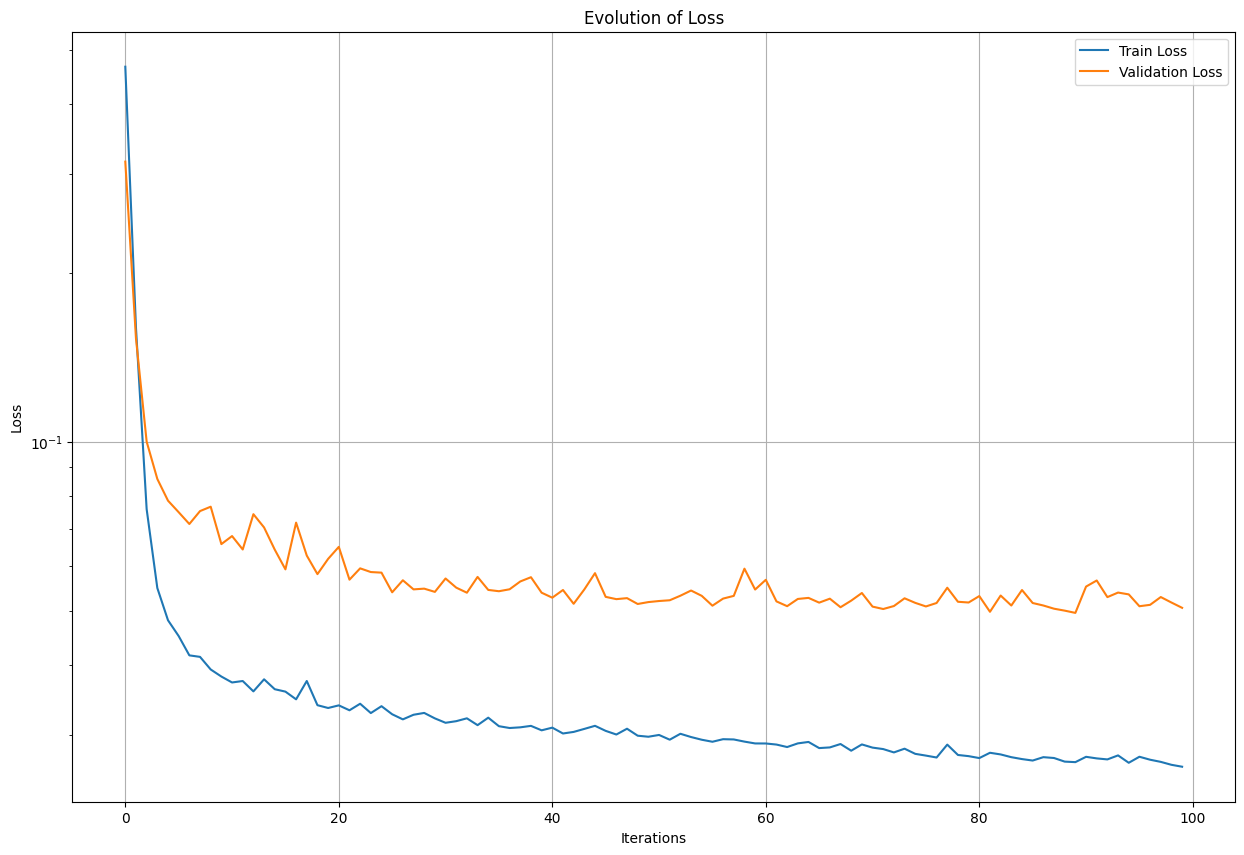

In [6]:
plot_train_val_loss(train_loss_values, val_loss_values)

## Test model

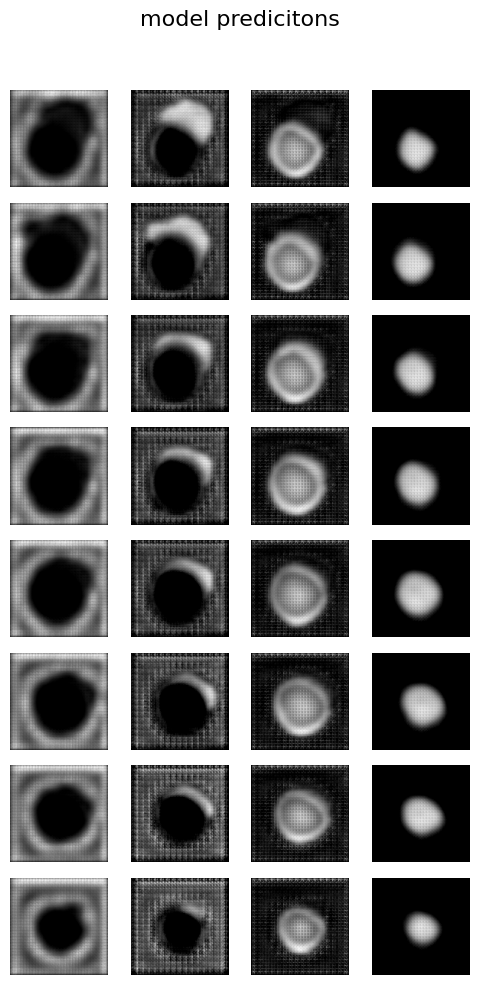

In [7]:
vis_batch = next(iter(TestLoader)).to(device)

batch_hat = reconstruct_logits(vis_batch, model)

visualize_batch_logits( batch_hat.detach().cpu(), title = "model predicitons")

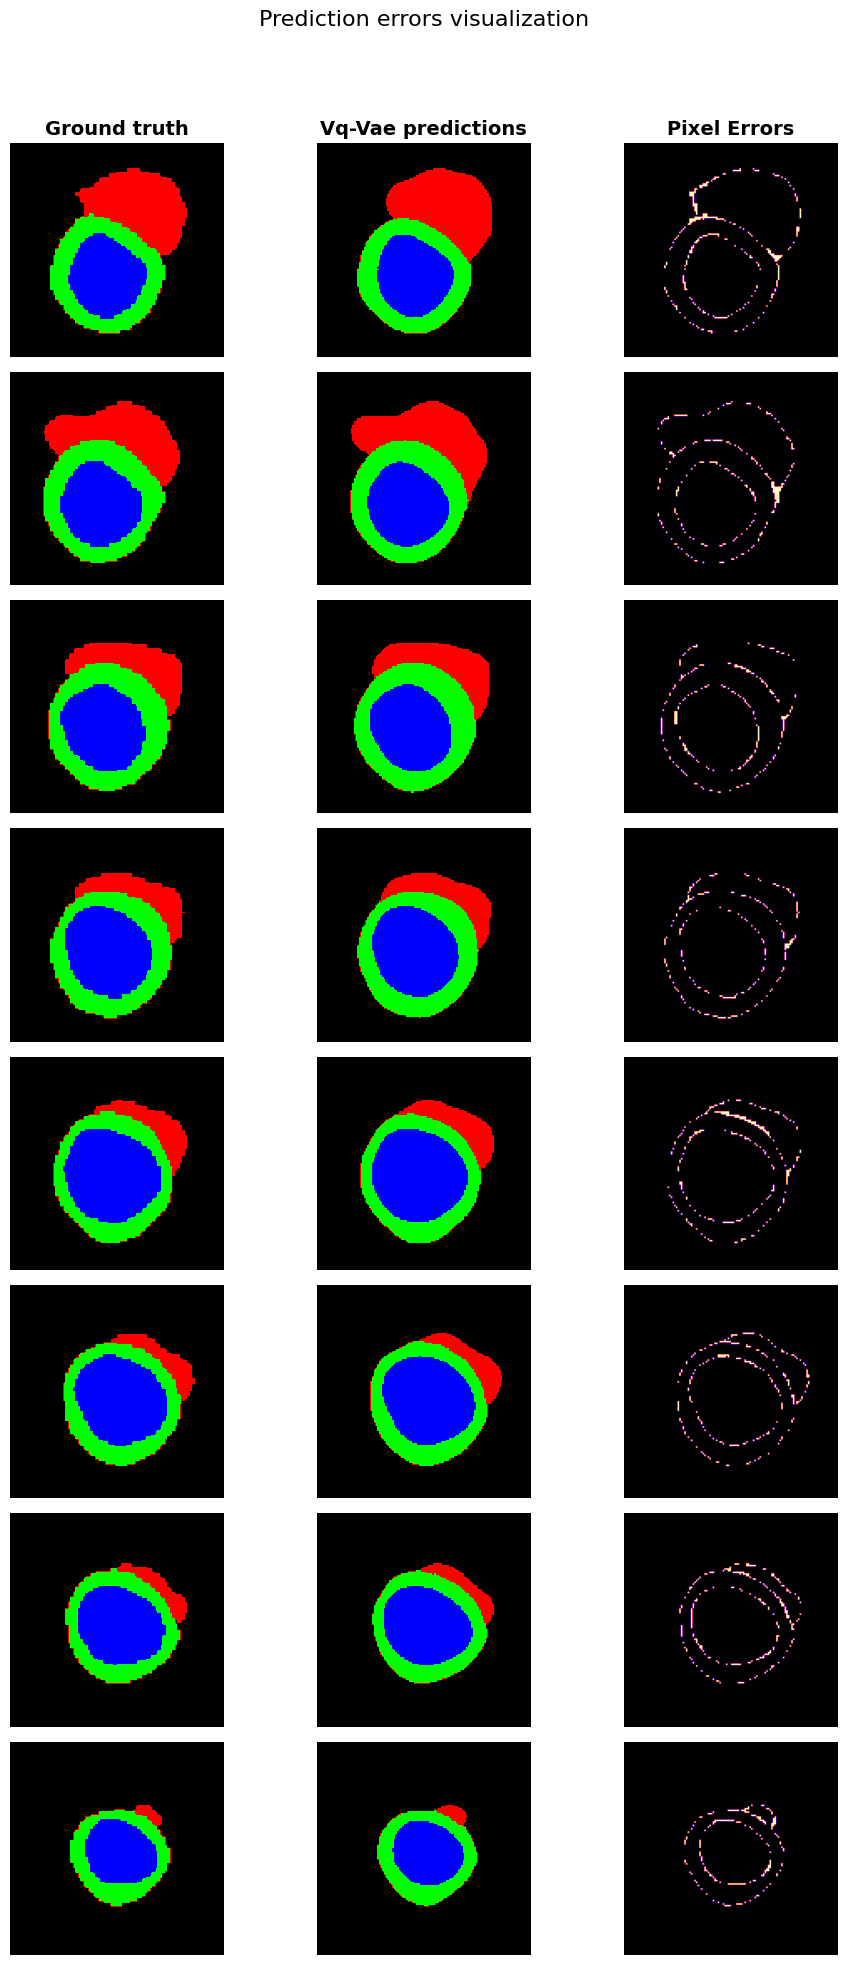

In [8]:

batch_hat = reconstruct_logits(vis_batch, model)
probs = F.softmax(batch_hat, dim=1) 

pred_seg = torch.argmax(probs,     dim=1).detach().cpu()
true_seg = torch.argmax(vis_batch, dim=1).detach().cpu()

visualize_errors(true_seg, pred_seg, 'Prediction errors visualization')

## Evaluate model score : 

In [9]:
# model_path = 'saved_models/seg_model_300.pth'

# model =  VQVAE(embedding_dim= D,
#                 num_embeddings= K,
#                 downsampling_factor= downsampling_factor,
#                 residual = use_residual,
#                 num_quantizers = num_quantizers,
#                 shared_codebook = shared_codebook,
#                 beta = beta,
#                 decay = decay,
#                 data_mod = data_modality
#                     )

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# model.load_state_dict(torch.load(model_path)['model_state_dict'])
# model = model.to(device)

In [10]:
print(score_model(model, TestLoader, device))

0.9494406002409318


### CodeBook usage :